In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
from torch import optim
from torchviz import make_dot
from tqdm import tqdm

In [2]:
# matplotlibの初期設定
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 14

Text(0.5, 1.0, 'ReLU関数')

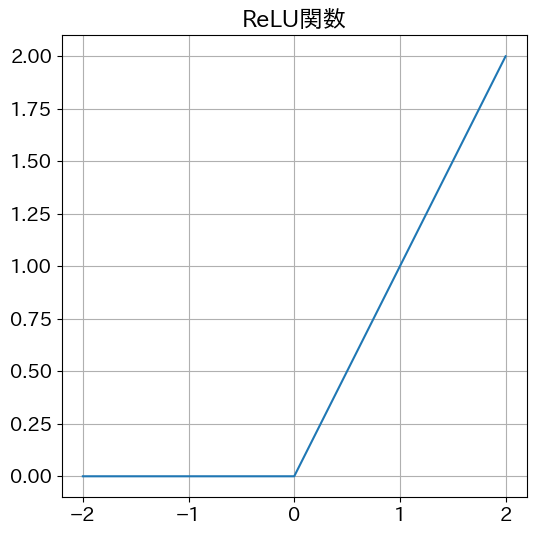

In [3]:
# ReLU関数の描画
relu = nn.ReLU()
X_np = np.arange(-2, 2.1, 0.25)
X = torch.tensor(X_np)
y = relu(X)

plt.plot(X.data, y.data)
plt.title('ReLU関数')


In [4]:
# GPUが使えるかの確認
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
# GPUには載せれない模様
X.to('cuda:0')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

こちらではcpuで処理を進める

## ミニバッチ学習法  

データ入力：Dataset  
データ加工:Transforms  
ミニバッチ用データセット生成：DataLoader  

In [6]:
# データ取得
import torchvision.datasets as datasets

data_root = "./hidden_dataset"

train_set0 = datasets.MNIST(
    root = data_root,
    train = True,
    download = True
)

In [7]:
# データ確認
!ls -1R  -l ./hidden_dataset/MNIST

./hidden_dataset/MNIST:
total 0
drwxr-xr-x 11 root root 352 Mar 17 01:53 raw

./hidden_dataset/MNIST/raw:
total 65500
-rw-r--r-- 1 root root  7840016 Mar 16 04:57 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Mar 16 04:57 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Mar 16 04:57 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Mar 16 04:57 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Mar 16 04:57 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Mar 16 04:57 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Mar 16 04:57 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Mar 16 04:57 train-labels-idx1-ubyte.gz


In [8]:
# データ件数
print('訓練データ件数', len(train_set0))

# 最初の要素
image, label = train_set0[0]

print('入力データ', type(image))
print('正解データ', type(label))


訓練データ件数 60000
入力データ <class 'PIL.Image.Image'>
正解データ <class 'int'>


(-0.5, 27.5, 27.5, -0.5)

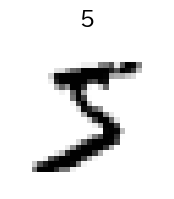

In [9]:
# 最初のデータの画像表示

plt.figure(figsize=(2, 2))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis(False)

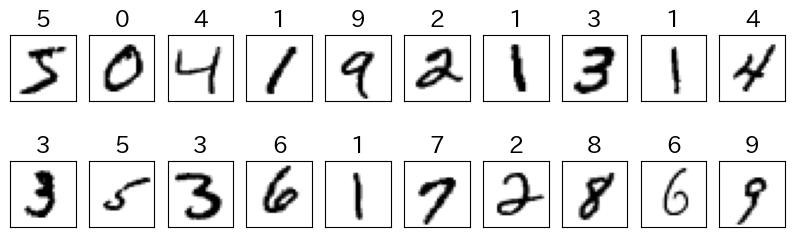

In [10]:
# 最初から20データの表示

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i+1)
    image, label = train_set0[i]
    plt.imshow(image, cmap='gray_r')
    plt.title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [11]:
# データ準備2 前処理

import torchvision.transforms as transforms

transform1 = transforms.Compose([transforms.ToTensor(),
                                ])

train_set1 = datasets.MNIST(root=data_root,
                            train=True,
                             download=True,
                             transform=transform1)



In [12]:
train_set1

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./hidden_dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [13]:
image, label = train_set1[0]
print(type(image))
print(image.shape)
print("min:", image.min())
print("max:", image.max())


<class 'torch.Tensor'>
torch.Size([1, 28, 28])
min: tensor(0.)
max: tensor(1.)


In [14]:
# テンソル化 + 正規化[-1, 1]
transform2 = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=0.5, std=0.5)
                                ])

train_set2 = datasets.MNIST(root=data_root,
                            train=True,
                             download=True,
                             transform=transform2)

In [15]:
image, label = train_set2[0]
print(type(image))
print(image.shape)
print("min:", image.min())
print("max:", image.max())


<class 'torch.Tensor'>
torch.Size([1, 28, 28])
min: tensor(-1.)
max: tensor(1.)


In [16]:
# テンソル化 + 正規化[-1, 1] + １次元化
transform3 = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=0.5, std=0.5),
                                 transforms.Lambda(lambda x : x.view(-1)),
                                ])

train_set3 = datasets.MNIST(root=data_root,
                            train=True,
                             download=True,
                             transform=transform3)

In [17]:
image, label = train_set3[0]

print('shape', image.shape)
print('min', image.min())
print('max', image.max())

shape torch.Size([784])
min tensor(-1.)
max tensor(1.)


In [18]:
# 最終的なデータセットの定義を前処理

# Transforms:
# iamgeのテンソル化
# [0, 1]を　[1, -1]に変換
# (1, 28, 28)を(784)の1階テンソル化
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5),
                                transforms.Lambda(lambda x : x.view(-1)),
                               ])


# 訓練データセットの定義
train_set = datasets.MNIST(root=data_root,
                           train=True,
                           download=True,
                           transform=transform)

# 検証データの定義
test_set = datasets.MNIST(root=data_root,
                           train=False,
                           download=True,
                           transform=transform)

In [19]:
# データ準備3 (ミニバッチ生成)

from torch.utils.data import DataLoader

# ミニバッチのサイズ指定
batch_size = 500

# 訓練用 shuffleをする
train_loader = DataLoader(dataset = train_set,
                          batch_size = batch_size,
                          shuffle = True)

# 検証用
test_loader = DataLoader(dataset = test_set,
                          batch_size = batch_size,
                          )

In [20]:
# train_loaderの確認
print(len(train_loader))

for images, label in train_loader:
    break

print(images.shape)
print(label.shape)

120
torch.Size([500, 784])
torch.Size([500])


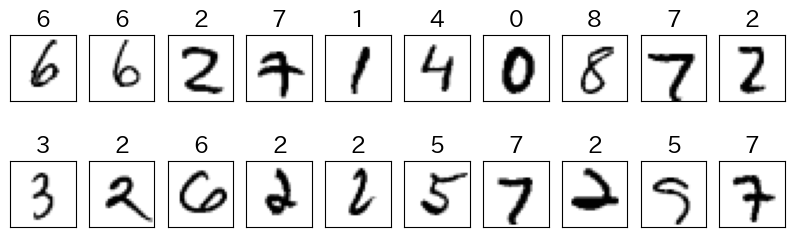

In [21]:
# imagesの最初の20画像を表示

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i+1)

    # imageをnumpy化
    np_img = images[i].numpy()
    # [-1, 1]を[0, 1]にする
    np_img = (np_img + 1) / 2

    # 描画
    plt.title(f'{label[i]}')
    plt.imshow(np_img.reshape(28, 28), cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
plt.show()

In [22]:
# モデルの定義
images, labels = next(iter(train_loader))
image = images[0]
num_label = len(labels.unique())

n_input = image.shape[0] # 784
n_output = num_label # 10
n_hidden = 128 

# モデル
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

# 乱数の設定

torch.manual_seed(123)
torch.cuda.manual_seed(123)

net = Net(n_input, n_output, n_hidden).to(device)

# 最適化
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr)

criterion = nn.CrossEntropyLoss()

In [23]:
# パラメータの確認
for param in net.named_parameters():
    print(param)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190,  0.0038,  0.033

In [24]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [25]:
for images, labels in train_loader:
    break

inputs = images.to(device)
labels = labels.to(device)

output = net(inputs)

loss = criterion(output, labels)

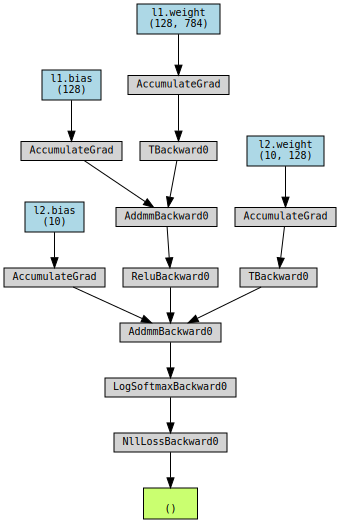

In [26]:
make_dot(loss, dict(net.named_parameters()))

In [27]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
# 決定論的アルゴリズムで再現性を実装
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True


lr = 0.01

net = Net(n_input, n_output, n_hidden)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr)

# エポック数
num_epoch = 100

# 評価結果記録用
history = np.zeros((0,5))

In [31]:

for epoch in range(num_epoch):
    # 1エポックあたりの精度
    n_train_acc, n_test_acc  = 0, 0
    # 1エポックあたりの損失
    train_loss, test_loss = 0, 0
    # 1エポックあたりのデータ累積件数
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader, desc='train'):
        train_batch_size = len(inputs)
        n_train += train_batch_size

        # gpu環境ではデータをgpuに送る
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 勾配の初期化
        optimizer.zero_grad()

        # predction
        outputs = net(inputs)

        # loss
        loss = criterion(outputs, labels)

        # 勾配計算、パラメータ更新
        loss.backward()
        optimizer.step()

        # predictionの予測ラベル
        _, pred_labels = torch.max(outputs, 1)

        # 全体のloss累積
        train_loss += loss.item()*train_batch_size
        # 正解数の累積
        n_train_acc += (pred_labels == labels).sum().item()


     # 予測フェーズ -> パラメータの更新はしないので注意!!
    for inputs, labels in tqdm(test_loader, desc='test'):
        test_batch_size = len(inputs)
        n_test += test_batch_size

        # gpu環境ではデータをgpuに送る
        inputs = inputs.to(device)
        labels = labels.to(device)

        # predction
        outputs = net(inputs)

        # loss
        loss = criterion(outputs, labels)

        # predictionの予測ラベル
        _, pred_labels = torch.max(outputs, 1)

        # 全体のloss累積
        test_loss += loss.item()*test_batch_size
        # 正解数の累積
        n_test_acc += (pred_labels == labels).sum().item()

    # 精度計算
    train_acc = n_train_acc / n_train
    test_acc = n_test_acc / n_test

    # 損失計算
    ave_train_loss = train_loss / n_train
    ave_test_loss = test_loss / n_test

     # 結果表示
    print (f'Epoch [{epoch+1}/{num_epoch}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f} test_loss: {ave_test_loss:.5f}, test_acc: {test_acc:.5f}')
    # 記録
    item = np.array([epoch+1 , ave_train_loss, train_acc, ave_test_loss, test_acc])
    history = np.vstack((history, item))

test: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch [1/100], loss: 0.42707 acc: 0.88362 test_loss: 0.39863, test_acc: 0.88990


test: 100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Epoch [2/100], loss: 0.40631 acc: 0.88813 test_loss: 0.38216, test_acc: 0.89380


test: 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Epoch [3/100], loss: 0.39043 acc: 0.89107 test_loss: 0.36716, test_acc: 0.89730


test: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]


Epoch [4/100], loss: 0.37768 acc: 0.89348 test_loss: 0.35617, test_acc: 0.89890


test: 100%|██████████| 20/20 [00:02<00:00,  6.99it/s]


Epoch [5/100], loss: 0.36717 acc: 0.89623 test_loss: 0.34770, test_acc: 0.90100


test: 100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


Epoch [6/100], loss: 0.35836 acc: 0.89803 test_loss: 0.33926, test_acc: 0.90410


test: 100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


Epoch [7/100], loss: 0.35067 acc: 0.89968 test_loss: 0.33373, test_acc: 0.90480


test: 100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


Epoch [8/100], loss: 0.34421 acc: 0.90150 test_loss: 0.32761, test_acc: 0.90550


test: 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


Epoch [9/100], loss: 0.33815 acc: 0.90277 test_loss: 0.32315, test_acc: 0.90810


test: 100%|██████████| 20/20 [00:03<00:00,  6.53it/s]


Epoch [10/100], loss: 0.33276 acc: 0.90465 test_loss: 0.31754, test_acc: 0.90920


test: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch [11/100], loss: 0.32783 acc: 0.90567 test_loss: 0.31479, test_acc: 0.90950


test: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch [12/100], loss: 0.32345 acc: 0.90672 test_loss: 0.31157, test_acc: 0.91260


test: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch [13/100], loss: 0.31917 acc: 0.90842 test_loss: 0.30696, test_acc: 0.91120


test: 100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Epoch [14/100], loss: 0.31530 acc: 0.90912 test_loss: 0.30292, test_acc: 0.91380


test: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


Epoch [15/100], loss: 0.31160 acc: 0.91037 test_loss: 0.29928, test_acc: 0.91460


test: 100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


Epoch [16/100], loss: 0.30816 acc: 0.91117 test_loss: 0.29653, test_acc: 0.91500


test: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]


Epoch [17/100], loss: 0.30486 acc: 0.91243 test_loss: 0.29417, test_acc: 0.91640


test: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]


Epoch [18/100], loss: 0.30170 acc: 0.91368 test_loss: 0.29162, test_acc: 0.91580


test: 100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [19/100], loss: 0.29857 acc: 0.91418 test_loss: 0.28862, test_acc: 0.91810


test: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]


Epoch [20/100], loss: 0.29587 acc: 0.91537 test_loss: 0.28761, test_acc: 0.91820


test: 100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Epoch [21/100], loss: 0.29282 acc: 0.91608 test_loss: 0.28402, test_acc: 0.91900


test: 100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Epoch [22/100], loss: 0.29014 acc: 0.91687 test_loss: 0.28088, test_acc: 0.92020


test: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


Epoch [23/100], loss: 0.28745 acc: 0.91798 test_loss: 0.27867, test_acc: 0.92010


test: 100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


Epoch [24/100], loss: 0.28463 acc: 0.91852 test_loss: 0.27726, test_acc: 0.92210


test: 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Epoch [25/100], loss: 0.28216 acc: 0.91950 test_loss: 0.27472, test_acc: 0.92130


test: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch [26/100], loss: 0.27973 acc: 0.91998 test_loss: 0.27286, test_acc: 0.92180


test: 100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


Epoch [27/100], loss: 0.27746 acc: 0.92047 test_loss: 0.27047, test_acc: 0.92200


test: 100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


Epoch [28/100], loss: 0.27489 acc: 0.92152 test_loss: 0.26816, test_acc: 0.92410


test: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


Epoch [29/100], loss: 0.27247 acc: 0.92208 test_loss: 0.26657, test_acc: 0.92350


test: 100%|██████████| 20/20 [00:02<00:00,  7.01it/s]


Epoch [30/100], loss: 0.27032 acc: 0.92277 test_loss: 0.26447, test_acc: 0.92500


test: 100%|██████████| 20/20 [00:02<00:00,  6.89it/s]


Epoch [31/100], loss: 0.26789 acc: 0.92383 test_loss: 0.26236, test_acc: 0.92540


test: 100%|██████████| 20/20 [00:02<00:00,  6.74it/s]


Epoch [32/100], loss: 0.26571 acc: 0.92403 test_loss: 0.26079, test_acc: 0.92490


test: 100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


Epoch [33/100], loss: 0.26339 acc: 0.92505 test_loss: 0.25891, test_acc: 0.92600


test: 100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epoch [34/100], loss: 0.26125 acc: 0.92573 test_loss: 0.25670, test_acc: 0.92700


test: 100%|██████████| 20/20 [00:03<00:00,  6.23it/s]


Epoch [35/100], loss: 0.25892 acc: 0.92577 test_loss: 0.25643, test_acc: 0.92700


test: 100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Epoch [36/100], loss: 0.25685 acc: 0.92687 test_loss: 0.25283, test_acc: 0.92800


test: 100%|██████████| 20/20 [00:02<00:00,  6.76it/s]


Epoch [37/100], loss: 0.25473 acc: 0.92723 test_loss: 0.25122, test_acc: 0.92820


test: 100%|██████████| 20/20 [00:03<00:00,  6.35it/s]


Epoch [38/100], loss: 0.25260 acc: 0.92797 test_loss: 0.24996, test_acc: 0.92770


test: 100%|██████████| 20/20 [00:02<00:00,  6.72it/s]


Epoch [39/100], loss: 0.25028 acc: 0.92857 test_loss: 0.24733, test_acc: 0.92990


test: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Epoch [40/100], loss: 0.24837 acc: 0.92922 test_loss: 0.24559, test_acc: 0.93090


test: 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Epoch [41/100], loss: 0.24635 acc: 0.93037 test_loss: 0.24383, test_acc: 0.93090


test: 100%|██████████| 20/20 [00:03<00:00,  6.15it/s]


Epoch [42/100], loss: 0.24432 acc: 0.93077 test_loss: 0.24176, test_acc: 0.93100


test: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


Epoch [43/100], loss: 0.24230 acc: 0.93112 test_loss: 0.24042, test_acc: 0.93120


test: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Epoch [44/100], loss: 0.24024 acc: 0.93168 test_loss: 0.23858, test_acc: 0.93220


test: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


Epoch [45/100], loss: 0.23833 acc: 0.93248 test_loss: 0.23665, test_acc: 0.93220


test: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s]


Epoch [46/100], loss: 0.23653 acc: 0.93323 test_loss: 0.23522, test_acc: 0.93350


test: 100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Epoch [47/100], loss: 0.23452 acc: 0.93370 test_loss: 0.23338, test_acc: 0.93300


test: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch [48/100], loss: 0.23263 acc: 0.93418 test_loss: 0.23181, test_acc: 0.93490


test: 100%|██████████| 20/20 [00:03<00:00,  6.05it/s]


Epoch [49/100], loss: 0.23065 acc: 0.93482 test_loss: 0.23003, test_acc: 0.93450


test: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]


Epoch [50/100], loss: 0.22877 acc: 0.93530 test_loss: 0.22890, test_acc: 0.93450


test: 100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Epoch [51/100], loss: 0.22706 acc: 0.93585 test_loss: 0.22634, test_acc: 0.93560


test: 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


Epoch [52/100], loss: 0.22523 acc: 0.93673 test_loss: 0.22505, test_acc: 0.93560


test: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


Epoch [53/100], loss: 0.22327 acc: 0.93703 test_loss: 0.22422, test_acc: 0.93540


test: 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


Epoch [54/100], loss: 0.22155 acc: 0.93767 test_loss: 0.22110, test_acc: 0.93680


test: 100%|██████████| 20/20 [00:03<00:00,  6.14it/s]


Epoch [55/100], loss: 0.21981 acc: 0.93813 test_loss: 0.21981, test_acc: 0.93710


test: 100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Epoch [56/100], loss: 0.21812 acc: 0.93845 test_loss: 0.21824, test_acc: 0.93670


test: 100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


Epoch [57/100], loss: 0.21627 acc: 0.93890 test_loss: 0.21720, test_acc: 0.93760


test: 100%|██████████| 20/20 [00:03<00:00,  6.23it/s]


Epoch [58/100], loss: 0.21461 acc: 0.93947 test_loss: 0.21488, test_acc: 0.93800


test: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Epoch [59/100], loss: 0.21288 acc: 0.94015 test_loss: 0.21325, test_acc: 0.93890


test: 100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [60/100], loss: 0.21128 acc: 0.94028 test_loss: 0.21179, test_acc: 0.93900


test: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Epoch [61/100], loss: 0.20965 acc: 0.94097 test_loss: 0.21053, test_acc: 0.93940


test: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch [62/100], loss: 0.20806 acc: 0.94138 test_loss: 0.20886, test_acc: 0.93850


test: 100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Epoch [63/100], loss: 0.20647 acc: 0.94195 test_loss: 0.20730, test_acc: 0.94020


test: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Epoch [64/100], loss: 0.20485 acc: 0.94245 test_loss: 0.20618, test_acc: 0.94050


test: 100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


Epoch [65/100], loss: 0.20317 acc: 0.94255 test_loss: 0.20443, test_acc: 0.94100


test: 100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


Epoch [66/100], loss: 0.20171 acc: 0.94323 test_loss: 0.20356, test_acc: 0.94140


test: 100%|██████████| 20/20 [00:02<00:00,  7.23it/s]


Epoch [67/100], loss: 0.20020 acc: 0.94367 test_loss: 0.20227, test_acc: 0.94130


test: 100%|██████████| 20/20 [00:02<00:00,  7.30it/s]


Epoch [68/100], loss: 0.19868 acc: 0.94407 test_loss: 0.20073, test_acc: 0.94140


test: 100%|██████████| 20/20 [00:02<00:00,  7.27it/s]


Epoch [69/100], loss: 0.19724 acc: 0.94422 test_loss: 0.19914, test_acc: 0.94180


test: 100%|██████████| 20/20 [00:02<00:00,  7.23it/s]


Epoch [70/100], loss: 0.19576 acc: 0.94485 test_loss: 0.19794, test_acc: 0.94260


test: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


Epoch [71/100], loss: 0.19426 acc: 0.94580 test_loss: 0.19666, test_acc: 0.94300


test: 100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


Epoch [72/100], loss: 0.19297 acc: 0.94553 test_loss: 0.19568, test_acc: 0.94280


test: 100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


Epoch [73/100], loss: 0.19142 acc: 0.94632 test_loss: 0.19355, test_acc: 0.94500


test: 100%|██████████| 20/20 [00:02<00:00,  7.32it/s]


Epoch [74/100], loss: 0.19017 acc: 0.94642 test_loss: 0.19245, test_acc: 0.94430


test: 100%|██████████| 20/20 [00:02<00:00,  7.33it/s]


Epoch [75/100], loss: 0.18872 acc: 0.94703 test_loss: 0.19127, test_acc: 0.94470


test: 100%|██████████| 20/20 [00:02<00:00,  6.82it/s]


Epoch [76/100], loss: 0.18730 acc: 0.94755 test_loss: 0.19100, test_acc: 0.94530


test: 100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


Epoch [77/100], loss: 0.18605 acc: 0.94763 test_loss: 0.18911, test_acc: 0.94570


test: 100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


Epoch [78/100], loss: 0.18476 acc: 0.94807 test_loss: 0.18736, test_acc: 0.94630


test: 100%|██████████| 20/20 [00:02<00:00,  7.25it/s]


Epoch [79/100], loss: 0.18344 acc: 0.94860 test_loss: 0.18660, test_acc: 0.94520


test: 100%|██████████| 20/20 [00:02<00:00,  6.93it/s]


Epoch [80/100], loss: 0.18219 acc: 0.94908 test_loss: 0.18506, test_acc: 0.94600


test: 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


Epoch [81/100], loss: 0.18079 acc: 0.94928 test_loss: 0.18449, test_acc: 0.94640


test: 100%|██████████| 20/20 [00:02<00:00,  6.99it/s]


Epoch [82/100], loss: 0.17959 acc: 0.94988 test_loss: 0.18293, test_acc: 0.94650


test: 100%|██████████| 20/20 [00:02<00:00,  6.85it/s]


Epoch [83/100], loss: 0.17837 acc: 0.95023 test_loss: 0.18215, test_acc: 0.94720


test: 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


Epoch [84/100], loss: 0.17701 acc: 0.95063 test_loss: 0.18026, test_acc: 0.94700


test: 100%|██████████| 20/20 [00:02<00:00,  7.29it/s]


Epoch [85/100], loss: 0.17603 acc: 0.95087 test_loss: 0.17935, test_acc: 0.94770


test: 100%|██████████| 20/20 [00:02<00:00,  7.27it/s]


Epoch [86/100], loss: 0.17480 acc: 0.95128 test_loss: 0.17973, test_acc: 0.94750


test: 100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


Epoch [87/100], loss: 0.17356 acc: 0.95195 test_loss: 0.17819, test_acc: 0.94880


test: 100%|██████████| 20/20 [00:02<00:00,  7.21it/s]


Epoch [88/100], loss: 0.17255 acc: 0.95175 test_loss: 0.17625, test_acc: 0.94770


test: 100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


Epoch [89/100], loss: 0.17140 acc: 0.95207 test_loss: 0.17518, test_acc: 0.94820


test: 100%|██████████| 20/20 [00:02<00:00,  7.25it/s]


Epoch [90/100], loss: 0.17024 acc: 0.95262 test_loss: 0.17496, test_acc: 0.94890


test: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch [91/100], loss: 0.16911 acc: 0.95277 test_loss: 0.17365, test_acc: 0.94930


test: 100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


Epoch [92/100], loss: 0.16795 acc: 0.95307 test_loss: 0.17232, test_acc: 0.94890


test: 100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Epoch [93/100], loss: 0.16701 acc: 0.95318 test_loss: 0.17157, test_acc: 0.94870


test: 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


Epoch [94/100], loss: 0.16582 acc: 0.95368 test_loss: 0.17028, test_acc: 0.95010


test: 100%|██████████| 20/20 [00:02<00:00,  7.27it/s]


Epoch [95/100], loss: 0.16479 acc: 0.95418 test_loss: 0.16940, test_acc: 0.95070


test: 100%|██████████| 20/20 [00:02<00:00,  7.03it/s]


Epoch [96/100], loss: 0.16378 acc: 0.95437 test_loss: 0.16878, test_acc: 0.95040


test: 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


Epoch [97/100], loss: 0.16268 acc: 0.95438 test_loss: 0.16877, test_acc: 0.95070


test: 100%|██████████| 20/20 [00:02<00:00,  7.33it/s]


Epoch [98/100], loss: 0.16168 acc: 0.95495 test_loss: 0.16701, test_acc: 0.94990


test: 100%|██████████| 20/20 [00:02<00:00,  7.33it/s]


Epoch [99/100], loss: 0.16068 acc: 0.95507 test_loss: 0.16609, test_acc: 0.95100


test: 100%|██████████| 20/20 [00:02<00:00,  7.31it/s]

Epoch [100/100], loss: 0.15981 acc: 0.95540 test_loss: 0.16481, test_acc: 0.95130


In [39]:
print('初期:損失', history[0, 3], '精度：', history[0, 4])
print('最終:損失', history[-1, 3], '精度：', history[-1, 4])


初期:損失 0.7966124132275582 精度： 0.8318
最終:損失 0.16481353398412465 精度： 0.9513
